<a href="https://colab.research.google.com/github/angusev/aibolit/blob/master/ranking_methods_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, \
        explained_variance_score, mean_squared_log_error, mean_tweedie_deviance
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                    PolynomialFeatures
from sklearn.decomposition import PCA
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets, linear_model, svm
import statsmodels.api as sm
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import seaborn as sns
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator
import lightgbm as lgbm

import csv
from itertools import permutations, combinations, chain, tee
import scipy.special
import random
import math
import networkx
import networkx.algorithms
import networkx as nx
from collections import defaultdict, OrderedDict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

%cd /content/gdrive/My Drive/aibolit

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/aibolit


In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_scores(y_test, y_pred):
    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    print('R2:  ', r2_score(y_test, y_pred))
    print('VAR:  ', np.var(y_test))

In [4]:
ONLY_PATTERNS = ['var_middle_number', 'nested_for_number', 'nested_if_number',
 'string_concat_number', 'instance_of_number', 'method_chain_number', 'var_decl_diff_number_5',
 'var_decl_diff_number_7', 'var_decl_diff_number_11', 'super_method_call_number',
 'for_type_cast_number', 'this_find_number', 'asserts_number', 'setter_number',
 'empty_rethrow_number', 'prohibited_class_names_number', 'return_in_if_number', 'impl_multi_number',
 'many_prim_ctors_number', 'multiple_try_number', 'non_final_field_number',
 'null_check_number', 'part_sync_number', 'red_catch_number', 'return_null_number']

FEATURES_NUMBER = len(ONLY_PATTERNS)
print("Number of features: ", FEATURES_NUMBER)

Number of features:  25


In [0]:
df = pd.read_csv('dataset8.csv')
df = df.dropna().drop_duplicates(subset=df.columns.difference(['filename']))
df = df[(df.ncss > 20) & (df.ncss < 500) & (df.cyclo < 100) & (df.cyclo > 3) 
                       & (df.npath_method_avg < 100000.00)].copy().reset_index()
                       
df = df[~df["filename"].str.lower().str.contains("test")]
filename_with_index = df['filename']
df.drop('filename', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)
columns_patterns =  ONLY_PATTERNS

X = pd.DataFrame(df[ONLY_PATTERNS].values / df['ncss'].values.reshape((-1, 1)))
#X = pd.DataFrame(df[ONLY_PATTERNS].values)
y = df[['cyclo']].values #/ df['ncss'].values.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3, random_state=42)

# NN Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List

class Maxout(nn.Module):
    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in, self.d_out, self.pool_size = d_in, d_out, pool_size
        self.lin = nn.Linear(d_in, d_out * pool_size)

    def forward(self, inputs):
        shape = list(inputs.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        max_dim = len(shape) - 1
        out = self.lin(inputs)
        m, i = out.view(*shape).max(max_dim)
        return m


class Net(nn.Module):
    def __init__(self, d, max_out_pool, n_features):
        super(Net, self).__init__()
        self.f = nn.Sequential(
            Maxout(n_features, d, max_out_pool),
            Maxout(d, d, max_out_pool),
            nn.Linear(d, 1)
        )

    def forward(self, x):
        return self.f(x)


class NNModel():
  def __init__(self, n_features):
    self.d = 50
    self.max_out_pool = 2
    self.n_features = n_features
    self.early_stop = 5
    self.lr = 0.002
    self.epochs = 200
    self.batch_size = 100
    self.committee_size = 10

  def _check_early_stoppping(self, score_history, epoch) -> bool:
    if (len(score_history) == 0): return False
    not_improve_counter = 0
    best = score_history[0]
    for i in range(0, epoch):
      if score_history[i] < best:
        not_improve_counter = 0
        best = score_history[i]
      else:
        not_improve_counter += 1

      if not_improve_counter >= self.early_stop:
        return True
    return False

  def _prepare_data(self, X_train, y_train, X_test, y_test):
    train_data = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train.values), 
        torch.FloatTensor(y_train)
    )
    val_data = torch.utils.data.TensorDataset(
      torch.FloatTensor(X_test.values), 
      torch.FloatTensor(y_test)
    )
    trainloader = torch.utils.data.DataLoader(
        train_data, batch_size=self.batch_size,
        shuffle=True)
    testloader = torch.utils.data.DataLoader(
        val_data, batch_size=self.batch_size,
        shuffle=False)
    return trainloader, testloader


  def _validate(self, model, dl, device=None):
    model.eval()
    test_loss = 0
    accuracy = 0
    preds = []
    all_labels = []
    criterion = torch.nn.MSELoss(reduction='none')
    losses = []

    with torch.no_grad():
        for inputs, labels in dl:
            pred = model.forward(inputs)
            batch_loss = criterion(pred.squeeze(1), labels.squeeze(1))
            all_labels += labels.tolist()
            preds += pred.tolist()
            losses += batch_loss.tolist()
          
    avg_loss = np.mean(losses)
    r2 = r2_score(all_labels, preds)
    mae = mean_absolute_error(all_labels, preds)
    y_true, y_pred = np.array(all_labels), np.array(preds)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true.reshape(-1), y_pred.reshape(-1)) 
    mse = mean_squared_error(y_true, y_pred) 
    return r2, avg_loss, mape, mae, mse

  def _train_model(self, trainloader, testloader, device=None):
    model = Net(self.d, self.max_out_pool, self.n_features)
    optimizer = optim.Adam(model.parameters(), lr=self.lr)
    criterion = torch.nn.MSELoss()
    best_params = None
    best_score = -200
    r2_epocs = {}

    for epoch in range(self.epochs):
      model.train()
      for inputs, labels in trainloader:
          optimizer.zero_grad()
          logps = model.forward(inputs)
          loss = criterion(logps.squeeze(1), labels.squeeze(1))
          loss.backward()
          optimizer.step()

      _, train_loss, _, _, _ = self._validate(model, trainloader, device)
      r2, valid_loss, mape, mae, mse = self._validate(model, testloader, device)
      r2_epocs[epoch] = -1 * r2
      if (best_score < r2):
          torch.save(model.state_dict(), './best.params.bin')
          best_score = r2

      if self._check_early_stoppping(r2_epocs, epoch):
        break

    model = Net(self.d, self.max_out_pool, self.n_features)
    model.load_state_dict(torch.load('./best.params.bin'))
    model.eval()
    return model, best_score

  def fit(self, X_train, y_train, X_test, y_test) -> None:
    trainloader, testloader = self._prepare_data(
        X_train, y_train, X_test, y_test
    )
    self.models = []
    self.best_scores = []
    for i in range(0, self.committee_size):
      model, best_score = self._train_model(trainloader, testloader)
      self.models.append(model)
      self.best_scores.append(best_score)

  def avg_score(self) -> float:
    return np.mean(self.best_scores)

  def predict(self, X: List[List[float]]) -> List[List[int]]:
    '''Takes in list of patterns tuples
       and for each combinaion returns list of pattern
       indexes ordered by importance 
    '''

    grad_accum = torch.zeros_like(torch.FloatTensor(X))
    for model in self.models:
      model.eval()
      x = torch.FloatTensor(X)
      x.requires_grad_(True)
      y = model(x)
      y.mean().backward()
      grad_accum += (x.grad.detach() * torch.FloatTensor([1])).softmax(dim=1)

    return np.array(grad_accum.argsort(dim=1, descending=True).tolist())


In [7]:
%%time

net = NNModel(n_features=FEATURES_NUMBER)
net.fit(X_train, y_train, X_test, y_test)
X = np.random.rand(2, FEATURES_NUMBER)

CPU times: user 20min 57s, sys: 4.94 s, total: 21min 2s
Wall time: 8min 14s


In [0]:
net_pred = net.predict(X_test.values)

In [9]:
trainloader, testloader = net._prepare_data(X_train, y_train, X_test, y_test)
net._validate(net.models[0], testloader)

(0.39466499182267356,
 183.05030892683692,
 70.16488783531297,
 8.977612075576173,
 183.05030913708086)

# Two fold model

In [10]:
! pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 64.4MB 51kB/s 


In [0]:
class TwoFoldRankingModel(BaseEstimator):
    importances = None
    model = None

    def __init__(self, tree_method='CatBoost'):
        if tree_method not in ['CatBoost', 'RF', 'LGBM']:
            raise "Unknown tree_method"
        self.tree_method = tree_method

    def fit(self, X, y):
        if self.tree_method == 'CatBoost':
            cat = CatBoostRegressor(verbose=0)
            cat.fit(X, y.ravel())
            self.model = cat
        elif self.tree_method == 'LGBM':
            lgbr = lgbm.LGBMRegressor(
                            learning_rate = 0.01, 
                            n_estimators = 1000
                            )
            lgbr.fit(X_train, y_train.ravel())
            self.model = lgbr
        elif self.tree_method == 'RF':
            rf_regr = RandomForestRegressor()
            rf_regr.fit(X_train, y_train)
            self.model = rf_regr
        
        self.importances = self.model.feature_importances_

    def predict(self, X, quantity_func='log'):   #  code snippet -- patterns representation
        patterns_number = self.importances.size
        ranked = []
        for snippet in X:
            if quantity_func == 'log':
                log_q = np.log(snippet + 1)
                pairs = np.vstack((log_q * self.importances,
                            np.arange(patterns_number))).T
            elif quantity_func == 'linear':
                pairs = np.vstack((snippet * self.importances,
                            np.arange(patterns_number))).T
            elif quantity_func == 'exp':
                exp_q = np.exp(snippet + 1)
                pairs = np.vstack((exp_q * self.importances,
                            np.arange(patterns_number))).T
            else:
                raise "Unknown func"
            pairs = pairs[pairs[:,0].argsort()]
            ranked.append(pairs[:,1].T.tolist()[::-1])

        return np.array(ranked)

    def recommend(self, snippet, display=False):
        log_q = np.log(snippet + 1)
        patterns_number = self.importances.size
        pairs = np.vstack((log_q * self.importances,
                           np.arange(patterns_number)))
        pairs = pairs.T.tolist()
        pairs.sort(reverse=True)
        pairs = list(map(lambda p: [p[0], int(p[1])], pairs))
        recommendation = ONLY_PATTERNS[pairs[0][1]]
        if display:
            print(recommendation)
        
        return recommendation


In [12]:
%%time 

twofold_model = TwoFoldRankingModel()
twofold_model.fit(X_train, y_train)

CPU times: user 16.7 s, sys: 1.1 s, total: 17.8 s
Wall time: 7.25 s


In [0]:
twofold_pred_log = twofold_model.predict(X_test.values, 'log')
twofold_pred_lin = twofold_model.predict(X_test.values, 'linear')

In [15]:
print_scores(y_test, twofold_model.model.predict(X_test))

MSE:  109.48457589638505
MAE:  6.442956222968394
MAPE: 49.84667085994198
R2:   0.6379419026498441
VAR:   302.3950484678696


# Pairwise SVM

In [0]:
def generate_full_permutations_dataset(X, y, desired_dataset_size=10000, filename="out.csv"):
    def to_bool(s):
        return 1 if s else 0

    def calc_closest_dataset_size_using_permutation(dataset_size):
        # 2-permuations of n =  n*(n-1)
        return int(math.sqrt(dataset_size))

    indices = []
    real_patterns_number = calc_closest_dataset_size_using_permutation(desired_dataset_size)
    random_indices = random.sample(range(X.shape[0]), real_patterns_number)
    perms = permutations(random_indices, 2)
    lst = list(perms)
    matrix = []
    for _, val in tqdm(enumerate(lst), total=len(lst)):
        d1, d2 = val[0], val[1]
        left_patterns = X[d1].tolist()
        right_patterns = X[d2].tolist()
        row = left_patterns + right_patterns
        target_left = y[d1]
        target_right = y[d2]
        target_cyclo = to_bool(target_left < target_right)
        matrix.append(row + [target_cyclo])

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(matrix)

In [0]:
class PairWiseSVM(BaseEstimator):
    params = {}
    model = None

    def __init__(self, params={'C': 1000, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}):
        self.params = params
    
    def fit(self, X, y):
        generate_full_permutations_dataset(X, y)
        dataset = pd.read_csv('out.csv', header=None)

        dataset = dataset.drop_duplicates(keep=False)
        y = dataset.iloc[:,-1]
        X = dataset.iloc[:,:-1]

        self.model = svm.SVC(**self.params)
        self.model.fit(X, y)

    def predict(self, X, display=False):
        ranked = []
        for arr in X:
            changed_arrs = []
            for i, item in enumerate(arr):
                elem = arr[i]
                if elem <= 0:
                    continue
                else:
                    arr_new = arr.copy()
                    arr_new[i] = arr[i] - 1
                    changed_arrs.append([i, arr_new])
            
            orders = []
            preds = defaultdict(dict)
            for elem1, elem2 in combinations(changed_arrs, 2):
                index_1 = elem1[0]
                index_2 = elem2[0]
                input_data = np.hstack((elem1[1], elem2[1])).reshape(1, -1)
                pred_p = self.model.predict_proba(input_data)
                pred = self.model.predict(input_data)
                if pred == 1:
                    orders.append([elem1[0], elem2[0]])
                else:
                    orders.append([elem2[0], elem1[0]])

            try:
                res = self.topological_sort(orders, display)
                ranked.append(res)
            except nx.NetworkXUnfeasible as e:
                raise 'We have a cycle in a graph, use another method'
        return ranked

    @staticmethod
    def topological_sort(sublists, display=False):
        graph = networkx.DiGraph(sublists)
        if display:
            networkx.draw(graph, with_labels=True, font_weight='bold')
        return list(networkx.algorithms.topological_sort(graph))


In [30]:
%%time

pw_model = PairWiseSVM()
pw_model.fit(X_train, y_train)

100%|██████████| 9900/9900 [00:00<00:00, 209214.35it/s]


CPU times: user 24.5 s, sys: 83.9 ms, total: 24.6 s
Wall time: 24.6 s


In [31]:
test_val = df[ONLY_PATTERNS].values[31].tolist()
print("Combinations of patterns to rank:", test_val)
ranked_list = pw_model.predict(X_test[30:31])
print('The ranked indicies: ', ranked_list)

Combinations of patterns to rank: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0]
The ranked indicies:  [[20, 16, 0, 5]]


In [16]:
X_test[30:31][0]

array([0.16326531, 0.        , 0.        , 0.        , 0.        ,
       0.16326531, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02040816, 0.        , 0.        , 0.        ,
       0.04081633, 0.        , 0.        , 0.        , 0.        ])

In [0]:
pw_pred = pw_model.predict(X_test)

# Comparison

In [0]:
net_pred = np.array(net_pred)
diff = twofold_pred_log - twofold_pred_lin

np.mean(np.std(diff / np.arange(1, FEATURES_NUMBER + 1)))

0.18289225003858278

In [0]:
sns.set(style='dark')

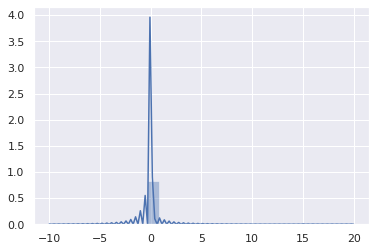

In [0]:
sns.distplot(diff[:,0], bins=FEATURES_NUMBER)
plt.grid()

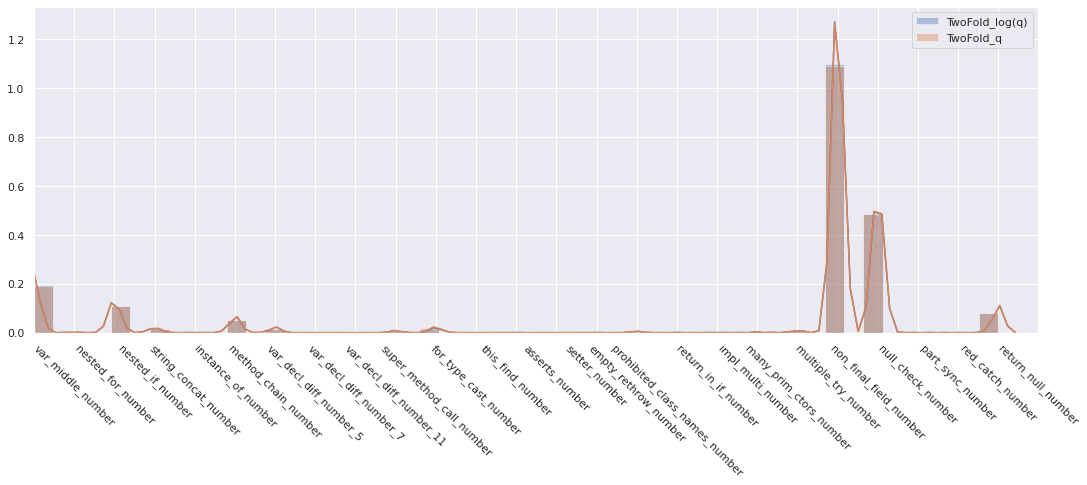

In [0]:
plt.figure(figsize=(18, 6))
sns.distplot(twofold_pred_log[:,0], label='TwoFold_log(q)')
sns.distplot(twofold_pred_lin[:,0], label='TwoFold_q')
plt.grid()
plt.xlim(0, FEATURES_NUMBER)
plt.xticks(range(1, FEATURES_NUMBER+1), labels=ONLY_PATTERNS, rotation=-45)
plt.legend();

In [0]:
len(twofold_pred_lin[twofold_pred_log[:,0] == twofold_pred_lin[:,0]]) / len(twofold_pred_lin[:,0])

0.9947203754399687